In [23]:
import qiskit
import numpy
from itertools import permutations 
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_histogram
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.transpiler import CouplingMap
%matplotlib inline

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-03-04 13:23:44,685: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
def generate_circuit_complete(n_qubits):
    A = numpy.ones((n_qubits, n_qubits))
    return qiskit.circuit.library.GraphState(A)

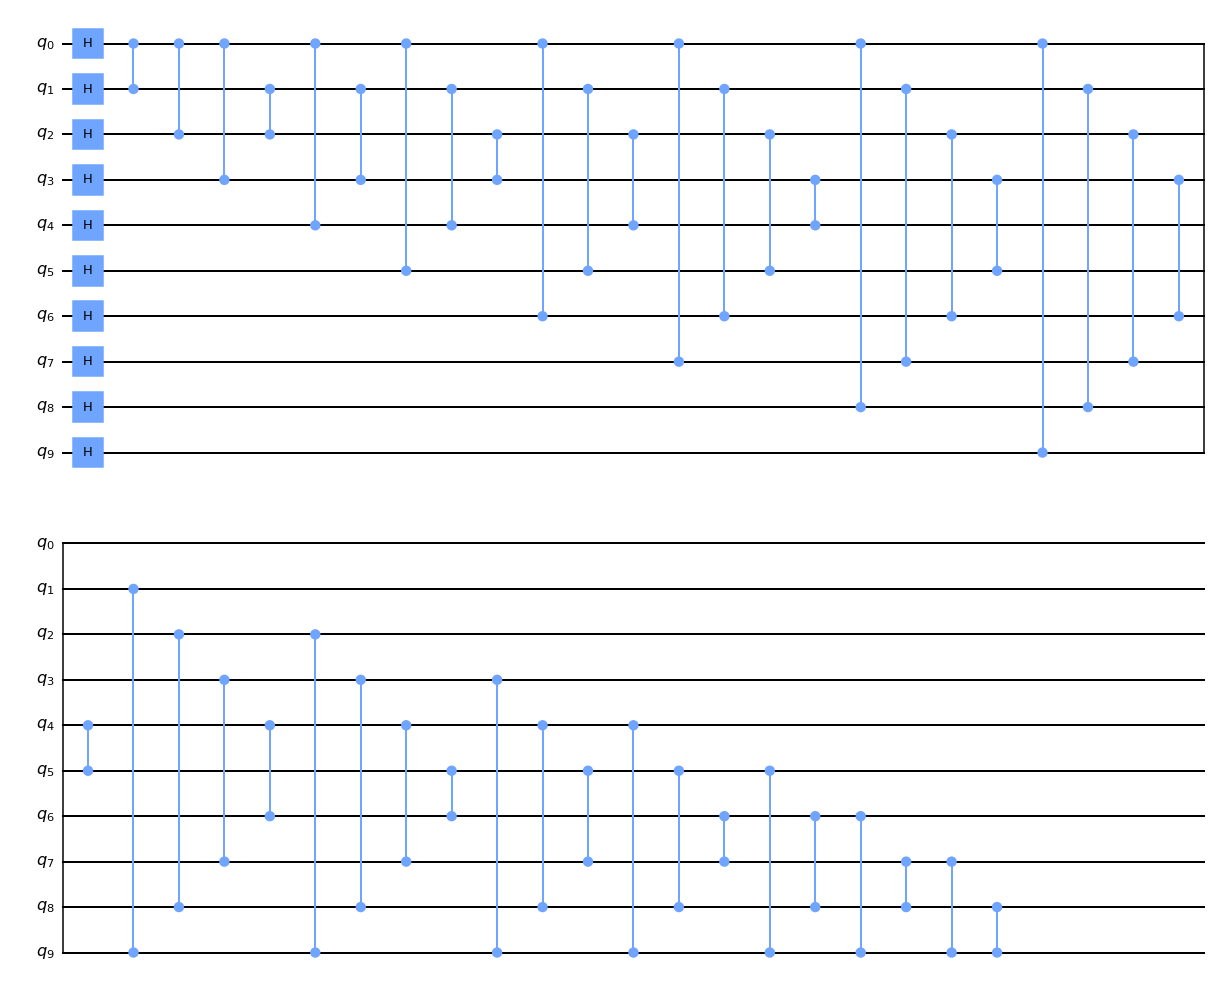

In [8]:
generate_circuit_complete(10).draw('mpl')

In [9]:
def generate_circuit_complete(n_qubits):
    # TODO only once CNOT per pair
    qc = QuantumCircuit(n_qubits)
    perm = permutations(range(n_qubits), 2)  
    for i in perm:  
        qc.cx(i[0], i[1])
    return qc

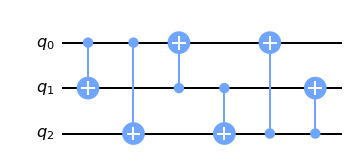

In [10]:
generate_circuit_complete(3).decompose().draw('mpl')

In [11]:
from qiskit.transpiler.passes import CSPLayout

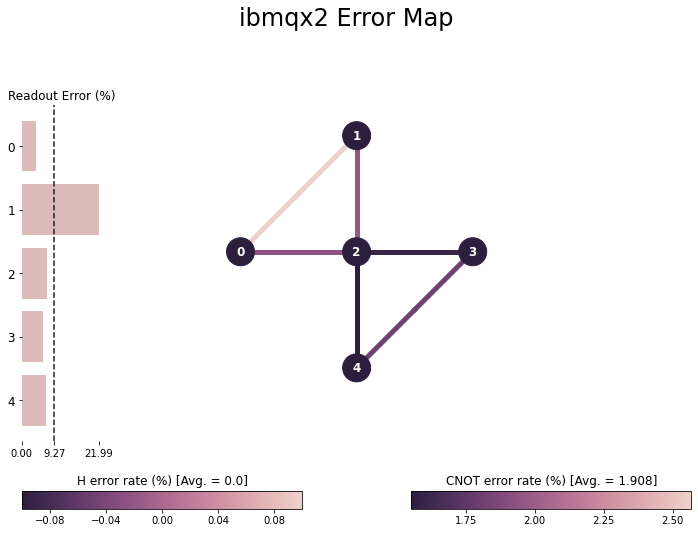

In [12]:
from qiskit.visualization.gate_map import plot_error_map
backend = provider.get_backend('ibmqx2')
plot_error_map(backend)

In [13]:
def run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs):
    pass_ = layout_selector(CouplingMap(backend.configuration().coupling_map), **kwargs)
    property_set = {}
    pass_(circuit, property_set)
    circuit._layout = property_set['layout']
    return circuit

def layout_on_circuit(circuit, layout_selector, backend, **kwargs):
    circuit = run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs)
    return plot_circuit_layout(circuit, backend)

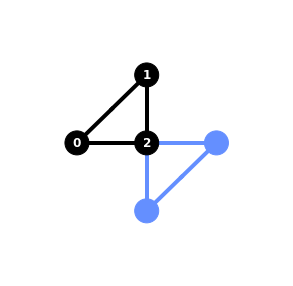

In [14]:
circuit = generate_circuit_complete(3)
layout_on_circuit(circuit, CSPLayout, backend, seed=42)

In [15]:
def generate_circuit_sub_coupling_map(coupling_map, list_of_physical_qubits):
    cm = backend.configuration().coupling_map
    def elected_edges(edge):
        if edge[0] not in list_of_physical_qubits:
            return False
        if edge[1] not in list_of_physical_qubits:
            return False
        return True

    rows = [list_of_physical_qubits.index(x[0]) for x in filter(elected_edges, cm)]
    cols = [list_of_physical_qubits.index(x[1]) for x in filter(elected_edges, cm)]

    n_qubits = len(list_of_physical_qubits)
    A = numpy.zeros((n_qubits, n_qubits))
    A[rows, cols] = 1

    qc = qiskit.circuit.library.GraphState(A)
    
    qc.measure_all()
    return qc

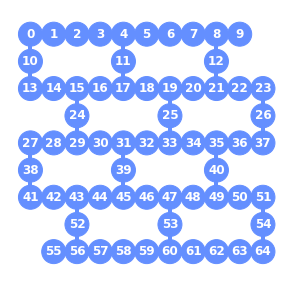

In [16]:
from qiskit.test.mock.backends import FakeManhattan
backend = FakeManhattan()
plot_gate_map(backend)

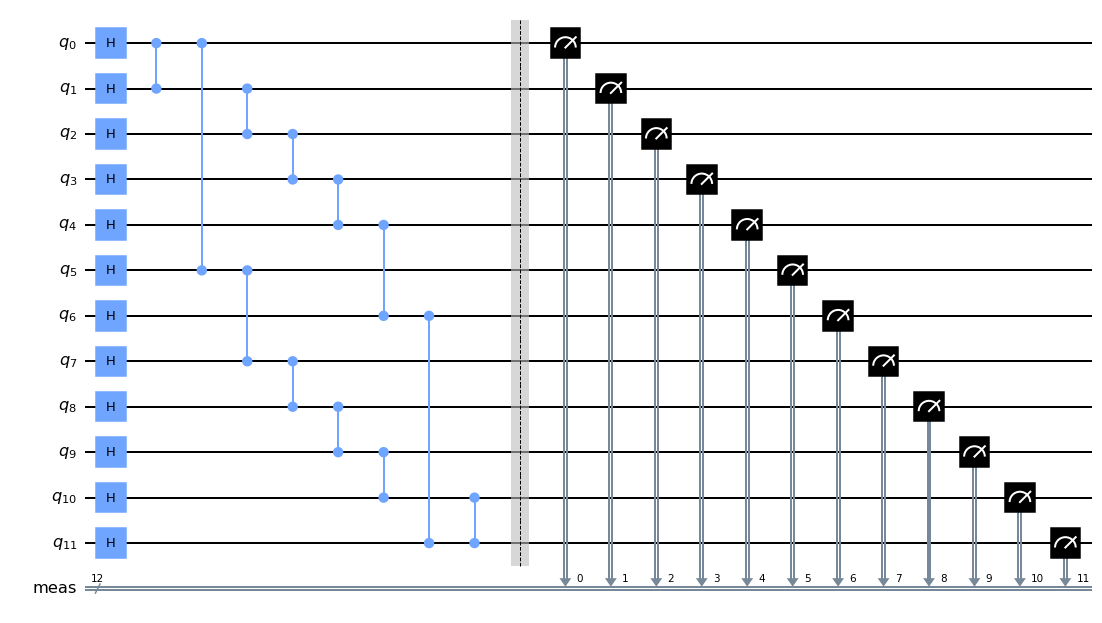

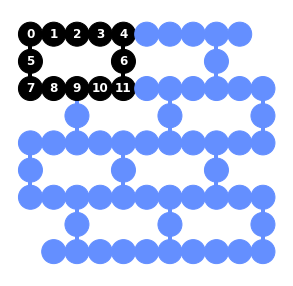

In [17]:
circuit = generate_circuit_sub_coupling_map(backend.configuration().coupling_map, [0,1,2,3,4,10,11,13,14,15,16,17])
# circuit = generate_circuit_sub_coupling_map(backend.configuration().coupling_map, [0,1])
display(circuit.draw('mpl'))
layout_on_circuit(circuit, CSPLayout, backend, seed=34000)

In [21]:
from qiskit.providers.aer import QasmSimulator

def evaluate(circuit, layout_selector, backend='ideal', **kwargs):
    if backend == 'ideal':
        simulator = QasmSimulator()
    else:
        circuit = run_layout_selector_on_circuit(circuit, CSPLayout, backend, **kwargs)
        simulator = QasmSimulator.from_backend(backend)
    return execute(circuit, simulator, shots=8192, memory=True).result()
    return result.get_counts(circuit)

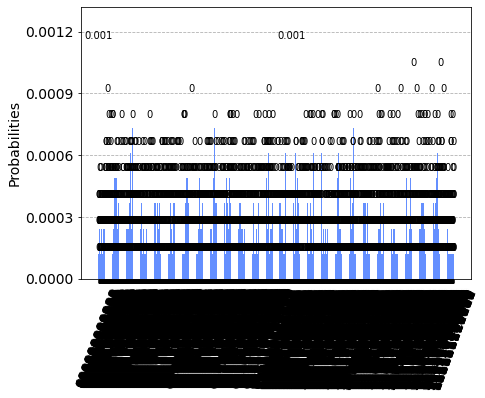

In [24]:
ideal_result = evaluate(circuit, CSPLayout, backend='ideal', seed=42)
plot_histogram(ideal_result.get_counts())

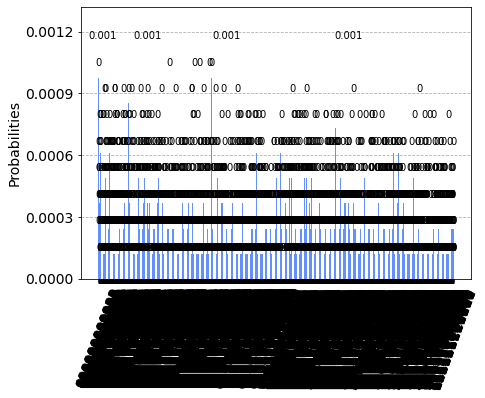

In [25]:
noise_result = evaluate(circuit, CSPLayout, backend=backend, seed=42)
plot_histogram(noise_result.get_counts())

In [29]:
ideal_result.get_counts()
ideal_result.get_memory()

['011001110101',
 '111100100011',
 '111100010000',
 '101111110000',
 '011001000001',
 '101001011010',
 '101000010110',
 '001010011111',
 '101110010100',
 '111001100110',
 '110011000110',
 '011010110011',
 '111111000111',
 '011100110100',
 '110111111010',
 '100011000101',
 '101101010111',
 '101011101000',
 '101110000000',
 '001000100110',
 '101011101100',
 '000110010000',
 '101001010100',
 '100101100000',
 '100010000010',
 '011000001010',
 '010001001100',
 '000111001100',
 '000000100111',
 '011100001001',
 '101101001011',
 '100110001100',
 '011110101010',
 '101000100100',
 '100101110001',
 '000010110010',
 '010000001101',
 '110011111000',
 '111000010010',
 '111000010100',
 '101000000000',
 '111101110010',
 '101101001100',
 '100010101010',
 '001010011111',
 '100000000100',
 '101110001010',
 '001010100010',
 '010101011101',
 '100011001100',
 '100011100010',
 '111111010100',
 '001001011100',
 '011011011000',
 '010001010111',
 '010111010100',
 '111101001101',
 '111001010000',
 '010011110000

In [39]:
ideal_counts = ideal_result.get_counts()
for noise_count in noise_result.get_counts():
    if noise_count not in ideal_counts:
        ideal_counts[noise_count] = 0
        
noise_counts = noise_result.get_counts()
for ideal_count in ideal_result.get_counts():
    if ideal_count not in noise_counts:
        noise_counts[ideal_count] = 0

In [54]:
from scipy.stats import entropy
entropy(list(ideal_counts.values()), qk=list(noise_counts.values()))

inf

In [53]:
from sklearn.metrics import mutual_info_score
mutual_info_score(list(ideal_counts.values()), list(noise_counts.values()))

0.34056916169943224